In [25]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import concurrent.futures

# Topic Modelling
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora
import nltk
from nltk.tokenize import word_tokenize
import gensim

import sys
sys.path.append('C:/Users/mulle/Documents/iCloudDrive/Documents/19. GITHUB/Crypto/scripts')

import os 
path = 'C:/Users/mulle/Documents/iCloudDrive/Documents/19. GITHUB/Crypto'
os.chdir(path)

from run_reddit_sentiment import preprocess_text 

In [9]:
btc_r = pd.read_csv('data/raw/reddit_raw/BTC_R.csv')
eth_r = pd.read_csv('data/raw/reddit_raw/ETH_R.csv')
sol_r = pd.read_csv('data/raw/reddit_raw/SOL_R.csv')
btc_r.selftext = btc_r.selftext.fillna('')
eth_r.selftext = eth_r.selftext.fillna('')
sol_r.selftext = sol_r.selftext.fillna('')

sol_r.date_posted = pd.to_datetime(sol_r.date_posted, utc=True)
sol_r.date_posted = sol_r.date_posted.dt.date
btc_r['all_text'] = btc_r['title'] + ' ' + btc_r['selftext']
eth_r['all_text'] = eth_r['title'] + ' ' + eth_r['selftext']
sol_r['all_text'] = sol_r['title'] + ' ' + sol_r['selftext']

sol_reddit = sol_r
eth_reddit = eth_r
btc_reddit = btc_r

In [10]:
btc_reddit

,subreddit,title,selftext,upvote_ratio,ups,downs,score,comments,date_posted,pull_date,all_text
0,Bitcoin,Bitcoin Newcomers FAQ - Please read!,# Welcome to the /r/Bitcoin Newcomers FAQ\n\nY...,0.95,194,0,194,148,2023-09-06,08:07.5,Bitcoin Newcomers FAQ - Please read! # Welcome...
1,Bitcoin,Are you still DCAing?,Or are you waiting for lower prices?,0.76,45,0,45,95,2024-02-05,08:07.5,Are you still DCAing? Or are you waiting for ...
2,Bitcoin,What happens if there are no miners at all?,Not really a relevant question as I can guaran...,0.37,0,0,0,35,2024-02-05,08:07.5,What happens if there are no miners at all? No...
3,Bitcoin,Where can I Download full node bitcoin ledger ...,"Hi, have some experience running bitcoin core ...",0.64,7,0,7,39,2024-02-04,08:07.6,Where can I Download full node bitcoin ledger ...
4,Bitcoin,Need good basic Spanish BTC video to convice m...,I am a big believer in BTC. It will slowly con...,0.67,10,0,10,38,2024-02-04,08:07.6,Need good basic Spanish BTC video to convice m...
...,...,...,...,...,...,...,...,...,...,...,...
14750,Bitcoin,"Florida: A third of ""Beer Can Island"" is up fo...",,0.81,23,0,23,9,2024-07-10,07/12/2024,"Florida: A third of ""Beer Can Island"" is up fo..."
14751,Bitcoin,Sell bitcoin from self custody 🚀,Hey! I’m Adam from bitcoinwell.com 👋🏼 \n\nWe’r...,0.71,25,0,25,67,2024-07-10,07/12/2024,Sell bitcoin from self custody 🚀 Hey! I’m Ada...
14752,Bitcoin,12 year old explains national debt in Canada,,0.93,1623,0,1623,163,2024-07-09,07/12/2024,12 year old explains national debt in Canada
14753,Bitcoin,Best MultiSig Providers?,What do you think are the best multisig provid...,0.56,1,0,1,2,2024-07-11,07/12/2024,Best MultiSig Providers? What do you think are...


In [13]:
def apply_preprocessing(df):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Submit all jobs, storing futures along with the index to preserve order
        futures = {executor.submit(preprocess_text, text): index for index, text in enumerate(df['all_text'])}
        results = [None] * len(df)  # Create a results list of the correct size

        # As each future completes, place the result in the correct position
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing Text"):
            index = futures[future]  # Get the original index
            results[index] = future.result()  # Store the result at the correct index

    return results
# Apply the function to each DataFrame
btc_reddit['processed_text'] = apply_preprocessing(btc_reddit)
eth_reddit['processed_text'] = apply_preprocessing(eth_reddit)
sol_reddit['processed_text'] = apply_preprocessing(sol_reddit)

Processing Text: 100%|██████████| 15385/15385 [00:36<00:00, 418.69it/s]


In [21]:
### Tokenize
nltk.download('punkt')  # Download the necessary tokenizer from NLTK

# Function to tokenize text
def tokenize(text):
    return word_tokenize(text.lower())  # Tokenize and convert to lower case

# Applying the tokenization function to your DataFrame
btc_reddit['tokens'] = btc_reddit['processed_text'].apply(tokenize)
eth_reddit['tokens'] = eth_reddit['processed_text'].apply(tokenize)
sol_reddit['tokens'] = sol_reddit['processed_text'].apply(tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mulle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
# Create a dictionary and corpus required for Topic Modeling
dictionary = corpora.Dictionary(btc_reddit['tokens'])
corpus = [dictionary.doc2bow(text) for text in btc_reddit['tokens']]

# Number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=2)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.068*"discussion" + 0.058*"please" + 0.051*"thread" + 0.043*"question" + 0.039*"daily" + 0.027*"bitcoin" + 0.025*"answer" + 0.024*"see" + 0.023*"post" + 0.023*"check"
Topic: 1 
Words: 0.063*"bitcoin" + 0.011*"wallet" + 0.011*"use" + 0.006*"key" + 0.006*"security" + 0.005*"transaction" + 0.005*"money" + 0.005*"resource" + 0.005*"unit" + 0.005*"check"
Topic: 2 
Words: 0.039*"bitcoin" + 0.022*"btc" + 0.013*"price" + 0.013*"year" + 0.010*"sell" + 0.010*"go" + 0.009*"buy" + 0.008*"not" + 0.008*"people" + 0.007*"market"
Topic: 3 
Words: 0.043*"bitcoin" + 0.013*"node" + 0.012*"mining" + 0.012*"miner" + 0.010*"run" + 0.009*"use" + 0.009*"block" + 0.008*"money" + 0.007*"government" + 0.006*"power"
Topic: 4 
Words: 0.106*"bitcoin" + 0.011*"saylor" + 0.009*"ask" + 0.009*"michael" + 0.009*"new" + 0.007*"first" + 0.006*"understand" + 0.005*"btc" + 0.005*"share" + 0.005*"transaction"
Topic: 5 
Words: 0.018*"seed" + 0.016*"key" + 0.015*"not" + 0.014*"use" + 0.012*"wallet" + 0.011*"b

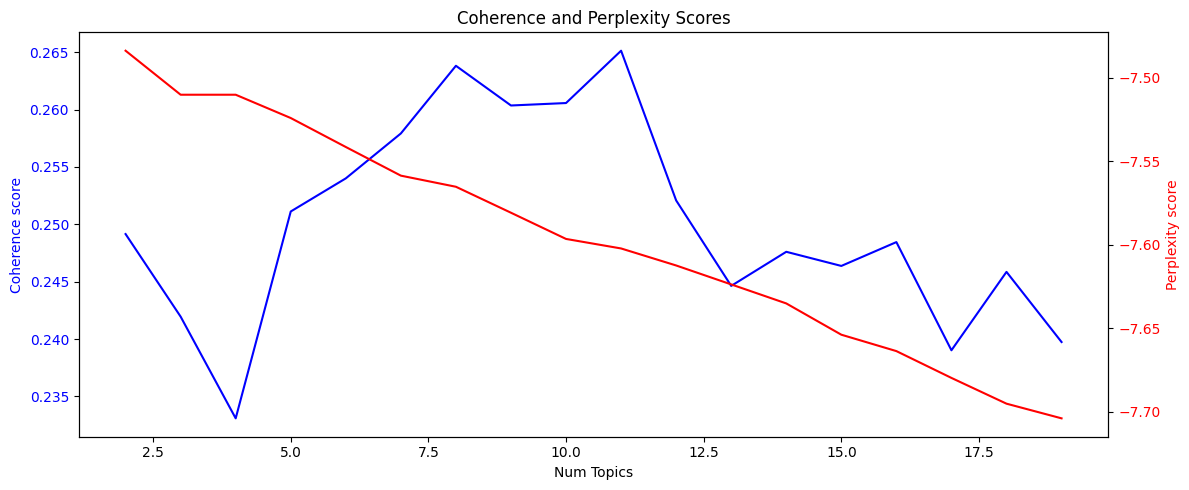

Optimal number of topics: 11


In [31]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

def evaluate_topic_numbers(corpus, dictionary, texts, start=2, limit=20, step=1):
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))
    
    # Plot
    x = range(start, limit, step)
    fig, ax1 = plt.subplots(figsize=(12,5))
    
    ax1.plot(x, coherence_values, 'b-', label='Coherence')
    ax1.set_xlabel('Num Topics')
    ax1.set_ylabel('Coherence score', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(x, perplexity_values, 'r-', label='Perplexity')
    ax2.set_ylabel('Perplexity score', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title('Coherence and Perplexity Scores')
    fig.tight_layout()
    plt.show()
    
    return model_list, coherence_values, perplexity_values

# Call the function
model_list, coherence_values, perplexity_values = evaluate_topic_numbers(corpus, dictionary, btc_reddit['tokens'])

# Find the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_model.num_topics}")